In [1]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from torchviz import make_dot
from PIL import Image
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch import optim
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from torchsummary import summary
%reload_ext autoreload
from Models import CNNModel1
%autoreload 2
from torch.utils.tensorboard import SummaryWriter
import cv2
from CustDataset import CustDataset
from ray import train, tune
from ray.tune.schedulers import ASHAScheduler
from sklearn.model_selection import StratifiedKFold, KFold
from ray.air import session
from ray.train import Checkpoint
from functools import partial
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR, ReduceLROnPlateau
from ray import train, tune
import os
import tempfile
import ray
from ray.tune.search.basic_variant import BasicVariantGenerator
import pandas as pd

Utils:

In [3]:
dir=r"C:\Users\margh\Desktop\ML2\ML2\Project\project 2\train" 
#Utils:
trans_dic2 = {  #for plotting
    0: 'astilbe',
    1: 'bellflower',
    2: 'black eyed susan',
    3: 'calendula',
    4: 'california poppy',
    5: 'carnation',
    6: 'common_daisy',
    7: 'coreopsis',
    8: 'dandelion',
    9: 'iris',
    10: 'rose',
    11: 'sunflower',
    12: 'tulip',
    13: 'water lily'
}
def show_images(data, num_to_show, ae=False, standardized=False):
    """Function that plots images, in case they have been standardized images are rescaled in [0,1]."""
    plt.figure(figsize = (20, 7))
    for i in range(num_to_show):
        if(ae):
            img = data[i]
        else:
            img = data[i][0]
        if(standardized):
             img = torch.clamp(img, min=0, max=1)    
        image = (img).permute((1, 2, 0)).numpy().squeeze()  
        if(not ae):
            label = trans_dic2[data[i][1]]
        plt.subplot(2, num_to_show, i + 1)
        plt.axis('off')
        plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        if(not ae):
            plt.title(str(label))
    plt.tight_layout()
    plt.show()


# Data preprocessing 

Load the data:

In [ ]:
data = torchvision.datasets.ImageFolder(dir)
print("Total number of samples: ", len(data))
print("Number of labels: ", len(set(data.targets)))

Split the data in train and test data. <br> 
The ratio is: 75% training data, 25% testing data. To ensure equal distribution of the labels the stratify option is used. <br>
Regarding the transformations on training and test images, they are first resized to (128,128) (original size: 3x256x256) in order to reduce a bit the computational time, without loosing to much information. Afterwards the images are normalized to $[0,1]$ (thus here divide by 255) and eventually standardized.

In [4]:
train_indices, test_indices, _, _ = train_test_split(
range(len(data)),
data.targets,
stratify = data.targets,  #ensures equal distribution of the labels in train and test set
test_size = 0.25,
shuffle = True, #to endorse randomness
random_state = 41
)

In [12]:
traindata_tmp = [cv2.resize(cv2.imread(data.samples[i][0]), (128,128)) for i in train_indices]

Compute mean and standard deviation of training and testing data:

In [ ]:
traindata_tmp = np.array(traindata_tmp)/255
mean_train = np.mean(traindata_tmp, axis=(1,2)).mean(axis=0)
std_train = np.std(traindata_tmp, axis=(1,2)).mean(axis=0)
#print("Mean and std for train set: ", mean_train, std_train)

Transformations for train and test data: resize+ normalize +standardize

In [14]:
data_transform_train = transforms.Compose([
     transforms.Resize((128,128)), 
     transforms.ToTensor(), #normalization
     transforms.Normalize(mean=mean_train, std=std_train)]) #standardization
data_transform_test = transforms.Compose([
     transforms.Resize((128,128)),  
     transforms.ToTensor(), #normalization
     transforms.Normalize(mean=mean_train, std=std_train)]) #standardization
data_transform_original = transforms.Compose([
     transforms.Resize((224,224)),
     transforms.ToTensor()]) #normalization and conversion to tensor

Create train and test datasets:

In [15]:
train_data_sub = torch.utils.data.Subset(data, train_indices)
train_data = CustDataset(subset=train_data_sub,transform=data_transform_train)
test_data_sub = torch.utils.data.Subset(data, test_indices)
test_data = CustDataset(subset=test_data_sub,transform=data_transform_test)
train_data_original = CustDataset(subset=train_data_sub,transform=data_transform_original)
test_data_original = CustDataset(subset=train_data_sub,transform=data_transform_original)

In [18]:
1.96*np.sqrt((1-0.7044)*0.7044)/np.sqrt(3411)

0.015313592992829736

In [16]:
print("Number of samples in train and test data:", len(train_data), len(test_data))

Number of samples in train and test data: 10231 3411


Show first 10 images of training set without standardization:

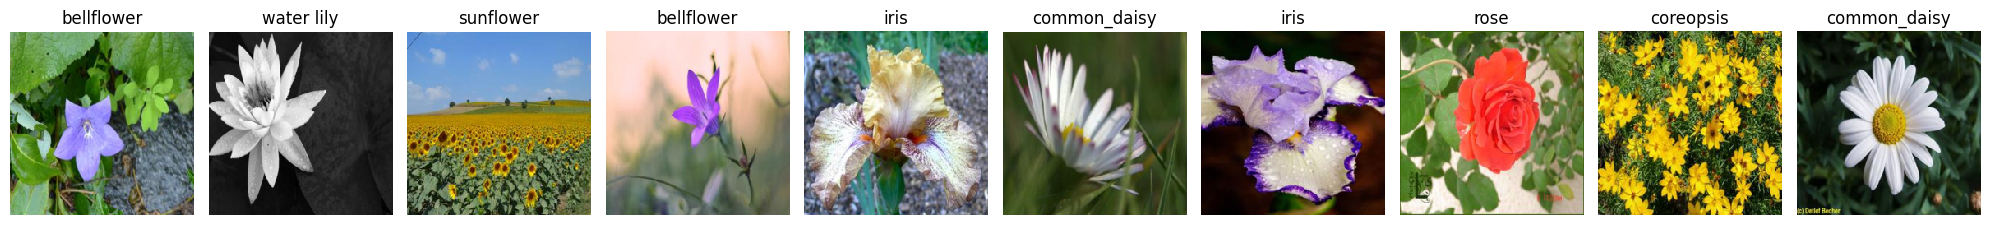

In [10]:
show_images(train_data_original, 10,standardized=True)

Show first 10 images of effective training data:

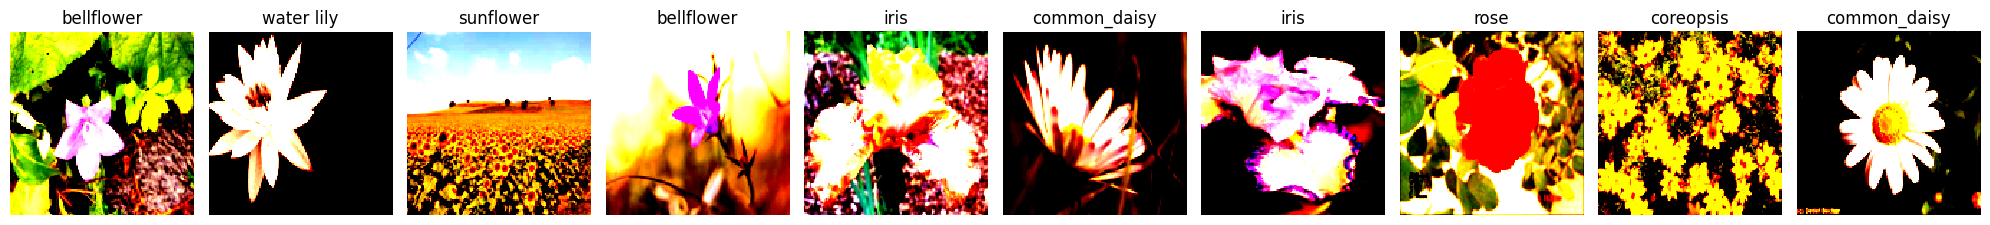

In [11]:
show_images(train_data,10, standardized=True)

# Model structure
 

In [17]:
numEpochs = 20
lr=0.01
loss_fun = nn.CrossEntropyLoss
model = CNNModel1(loss_fn=loss_fun,epochs=numEpochs,fc_dropout_rate=0.5, weight_decay=0.001, scheduler=True, channels1=32, channels2=64) #the scheduler is ExponentialLR
print(model)
print("Number of parameters: ",model.get_num_params())

torch.Size([512, 4096]) torch.Size([512])
torch.Size([14, 512]) torch.Size([14])
CNNModel1(
  (convolutions): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(64, 6

# Hyperparameters tuning
Perform a grid search cross validation with 5 folds on training data. <br>
To optimize the search through hpyerparameters space I use the asynchronous Hyperband Successive Halving algorithm (RayTune implementation).

In [10]:
def train_config(train_indices, y_train, cvfolds, config):
    trainloaders = []
    validloaders = []
    for train_indices_, val_indices in cvfolds.split(train_indices, y_train):
        validloaders.append(DataLoader(train_data, batch_size =128,sampler=torch.utils.data.SubsetRandomSampler(val_indices)))
        trainloaders.append(DataLoader(train_data, batch_size = 128,sampler=torch.utils.data.SubsetRandomSampler(train_indices_)))
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available
    
    net_fold1 = CNNModel1(fc_dropout_rate=0.5, fc_size=512, loss_fn=nn.CrossEntropyLoss, channels2=64, channels1=32, optim_type='SGD')
    net_fold1.to(device)
    optimizer_fold1 = optim.SGD(net_fold1.parameters(),lr=config['lr'], weight_decay=config['weight_decay'], momentum=0.9)

    
    net_fold2 = CNNModel1(fc_dropout_rate=0.5, fc_size=512, loss_fn=nn.CrossEntropyLoss, channels2=64, channels1=32, optim_type='SGD')
    net_fold2.to(device)
    optimizer_fold2 = optim.SGD(net_fold2.parameters(),lr=config['lr'], weight_decay=config['weight_decay'], momentum=0.9)
 

    
    net_fold3 = CNNModel1(fc_dropout_rate=0.5, fc_size=512, loss_fn=nn.CrossEntropyLoss, channels2=64, channels1=32, optim_type='SGD')
    net_fold3.to(device)
    optimizer_fold3 = optim.SGD(net_fold3.parameters(),lr=config['lr'], weight_decay=config['weight_decay'], momentum=0.9)

    
    net_fold4 = CNNModel1(fc_dropout_rate=0.5, fc_size=512, loss_fn=nn.CrossEntropyLoss, channels2=64, channels1=32, optim_type='SGD')
    net_fold4.to(device)
    optimizer_fold4 = optim.SGD(net_fold4.parameters(),lr=config['lr'], weight_decay=config['weight_decay'], momentum=0.9)
  
    
    net_fold5 = CNNModel1(fc_dropout_rate=0.5, fc_size=512, loss_fn=nn.CrossEntropyLoss, channels2=64, channels1=32, optim_type='SGD')
    net_fold5.to(device)
    optimizer_fold4 = optim.SGD(net_fold5.parameters(),lr=config['lr'], weight_decay=config['weight_decay'], momentum=0.9)
    

    

    
    nets = [net_fold1, net_fold2, net_fold3, net_fold4, net_fold5]
    optimizers = [optimizer_fold1, optimizer_fold2, optimizer_fold3,optimizer_fold4, optimizer_fold5]
    loss = nn.CrossEntropyLoss

    classes = list(y_train[0].unique())
    class_weights = list(class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=np.array(y_train[0])))
       
    
    checkpoint = session.get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))
            start_epoch = checkpoint_dict["epoch"] + 1
    else:
        start_epoch = 0
        
    for epoch in range(start_epoch, 20): 
        val_f1_score_over_folds = [] 
        val_losses_over_folds = []
        
        for fold,trainloader, valloader in zip([0,1,2,3,4], trainloaders, validloaders): #do it for every fold
            nets[fold].train()
            train_losses_fold = []
            #Train
            for batch in trainloader:
                classes = list(np.array(torch.unique(batch[1])))
                if (len(classes) < 14):
                    continue
                loss_ = loss(weight=torch.Tensor(class_weights))  #Add weighting to the loss 
                optimizers[fold].zero_grad() 
                input_features = batch[0].to(device)
                #One hot  encode for cross entropy loss:
                target = nn.functional.one_hot(batch[1], 14).to(device) 
                logits = nets[fold](input_features)  #Model's output, to get probabilities: call softmax on logits, but in pytorch loss fun expects the logits --> no need to have them in [0,1]
                ce = loss_(logits, target.float()) # Compute the loss
                train_losses_fold.append(ce.detach().cpu().item())
                ce.backward() # Backpropagate and calculate gradients wrt loss, this go in reverse into the computational graph--> gradient for each weight matrix
                torch.nn.utils.clip_grad_norm_(nets[fold].parameters(), 1) #Clip gradients to avoid large gradients (risk: overflow and have to rerune entire training round). Clipping divides by gradient's norm, thus the direction doesn't change
                optimizers[fold].step() # Update model parameters (weights): gradient descent update step 
                predicted_classes = logits.argmax(axis=1)  #Take as predicted class the one with highest probability
                observed_classes = target.argmax(axis=1)
            # Validation
            nets[fold].eval()
            val_f1_fold = []
            val_losses_fold = []
            for batch in valloader:
                with torch.no_grad():
                    classes = list(np.array(torch.unique(batch[1])))
                    if(len(classes)<14):
                        continue
                    loss_ = loss()  
                    input_features = batch[0].to(device)
                    target = nn.functional.one_hot(batch[1], 14).to(device)     
                    logits = nets[fold](input_features) 
                    ce = loss_(logits, target.float()) 
                    val_loss = ce.detach().cpu().item()
                    val_losses_fold.append(val_loss)
                    predicted_classes = logits.argmax(axis=1) 
                    observed_classes = target.argmax(axis=1)
                    sample_class_weights = [class_weights[i] for i in observed_classes] 
                    f1_val = f1_score(y_true=observed_classes, y_pred=predicted_classes, average='weighted', sample_weight=sample_class_weights)
                    val_f1_fold.append(f1_val)
            val_f1_score_over_folds.append(np.mean(val_f1_fold)) 
            val_losses_over_folds.append(np.mean(val_losses_fold))
        cv_mean_f1 = np.mean(val_f1_score_over_folds)
        cv_loss = np.mean(val_losses_over_folds)

        with tempfile.TemporaryDirectory() as tempdir:
            torch.save(
                {"epoch": epoch, "model_state": net_fold1.state_dict()},
                os.path.join(tempdir, "checkpoint.pt"),
            )
            session.report(metrics={"mean_validation_loss_cv": cv_loss, "mean_f1_score_cv": cv_mean_f1}, checkpoint=Checkpoint.from_directory(tempdir)) #print cross validated scores
    print("Finished Training")
def performcv(train_indices, y_train, cvfolds, config, num_samples=1, max_num_epochs=20):
        ray.shutdown()
        ray.init()
        scheduler = ASHAScheduler(
        metric = "mean_f1_score_cv",
        mode = "max",
        max_t = max_num_epochs,  
        grace_period = 5,
        reduction_factor = 2 
        
        )
        
        ! rm -rf ~/ray_results/gridsearchcv 
        analysis = tune.run(
            partial(train_config, train_indices, y_train, cvfolds),
            resources_per_trial={"cpu": 1, "gpu": 0},
            config = config,
            num_samples = num_samples, #Number of times to sample from the hyperparameter space, for grid search cv set it to 1
            scheduler = scheduler, #ASHA 
            name = "gridsearchcvnew2"
        )
        best_trial = analysis.get_best_trial("mean_f1_score_cv", "max", "last")
        print(f"Best trial config: {best_trial.config}")
        print(f"Best trial final validation loss: {best_trial.last_result['mean_validation_loss_cv']}")
        print(f"Best trial final validation f1 score: {best_trial.last_result['mean_f1_score_cv']}")  
        return analysis #return analysis results

In [13]:
%load_ext tensorboard

In [11]:
#Set hyperparameters space
config = {
        "lr": tune.grid_search([0.01, 0.001]), #tune.loguniform(1e-3, 1e-1)
        "weight_decay": tune.grid_search([0.0001, 0.001, 0.00001])
}
cvfolds=StratifiedKFold(n_splits=5, shuffle=True)  #balanced distribution of the classes
y_train = [data.samples[i][1] for i in train_indices] 
y_train = pd.DataFrame(y_train)
y_train.index = train_indices
cv_analysis = performcv(train_indices,y_train, cvfolds, config)

Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2024-03-18 16:37:21,132	INFO worker.py:1744 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
'rm' is not recognized as an internal or external command,
operable program or batch file.
2024-03-18 16:37:22,441	INFO tune.py:613 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(func pid=24952) torch.Size([512, 4096]) torch.Size([512])
(func pid=24952) torch.Size([14, 512]) torch.Size([14])


(func pid=24952) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/margh/ray_results/gridsearchcvnew2/train_config_69bd4_00005_5_lr=0.0010,weight_decay=0.0000_2024-03-18_16-37-22/checkpoint_000000)


Trial name,mean_f1_score_cv,mean_validation_loss_cv,should_checkpoint
train_config_69bd4_00000,0.522596,1.34743,True
train_config_69bd4_00001,0.334782,1.89424,True
train_config_69bd4_00002,0.730673,1.03545,True
train_config_69bd4_00003,0.344062,1.91111,True
train_config_69bd4_00004,0.667775,0.970405,True
train_config_69bd4_00005,0.368607,1.86606,True


(func pid=26312) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/margh/ray_results/gridsearchcvnew2/train_config_69bd4_00001_1_lr=0.0010,weight_decay=0.0001_2024-03-18_16-37-22/checkpoint_000000) [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(func pid=21260) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/margh/ray_results/gridsearchcvnew2/train_config_69bd4_00000_0_lr=0.0100,weight_decay=0.0001_2024-03-18_16-37-22/checkpoint_000001)
(func pid=24952) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/margh/ray_results/gridsearchcvnew2/train_config_69bd4_00005_5_lr=0.0010,weight_decay=0.0000_2024-03-18_16-37-22/checkpoint_000001)
(func pid=26312) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users

Best trial config: {'lr': 0.01, 'weight_decay': 0.001}
Best trial final validation loss: 1.0354452095925808
Best trial final validation f1 score: 0.7306725693490355


# Model evaluation
Select the model corresponding to the  hyperparametrs configuartion with highest cross validated f1_score and train it on the whole training set. Eventually, evaluate it on the test set and get final estimate for the evaluation metric.
At the end the final model will be the one retrained on all the data (train+test)  with final f1_score estimate the one obtained when evaluating on test data.

In [16]:
trainloader = DataLoader(train_data, batch_size = 128, shuffle = True)
testloader = DataLoader(test_data, batch_size =128, shuffle = True)

In [17]:
writer1 = SummaryWriter('EvaluationBestConfiguration5')

In [38]:
numEpochs = 20
lr = 0.01
loss_fun = nn.CrossEntropyLoss
y_test = [data.samples[i][1] for i in test_indices]
y_train = [data.samples[i][1] for i in train_indices] 
y_train = pd.DataFrame(y_train)
class_weights_test = list(class_weight.compute_class_weight(class_weight='balanced', classes=list(set(y_test)), y=np.array(y_train[0])))
class_weights_train = list(class_weight.compute_class_weight(class_weight='balanced', classes=list(y_train[0].unique()), y=np.array(y_train[0])))
model = CNNModel1(lr=lr, loss_fn=loss_fun,epochs=numEpochs,fc_dropout_rate=0.5, weight_decay=0.001, scheduler=False, optim_type='SGD')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model.to(device)
model.to(device)
print(model.get_num_params())
train_accs, train_loss, test_accs, test_loss=model.fit(trainloader, testloader, device, class_weights_train, class_weights_test, writer1)

torch.Size([512, 4096]) torch.Size([512])
torch.Size([14, 512]) torch.Size([14])
2239406
epoch: 1/20, train_f1_score: 0.2556478358154226, test_f1_score: 0.40639008659070364
epoch: 2/20, train_f1_score: 0.4259311714706298, test_f1_score: 0.48887856190390067
epoch: 3/20, train_f1_score: 0.4937088038718274, test_f1_score: 0.5270927497510394
epoch: 4/20, train_f1_score: 0.5375181843735212, test_f1_score: 0.5572877730256075
epoch: 5/20, train_f1_score: 0.5708015869171132, test_f1_score: 0.5439127819954381
epoch: 6/20, train_f1_score: 0.5994865755189001, test_f1_score: 0.6108169419164675
epoch: 7/20, train_f1_score: 0.629390877316458, test_f1_score: 0.6107510397147116
epoch: 8/20, train_f1_score: 0.6454314693520199, test_f1_score: 0.598807750959083
epoch: 9/20, train_f1_score: 0.6632651574441029, test_f1_score: 0.650992883770585
epoch: 10/20, train_f1_score: 0.6793898969329265, test_f1_score: 0.541648422205653
epoch: 11/20, train_f1_score: 0.6955356351421207, test_f1_score: 0.602528427989224

Text(0.5, 0, 'epoch')

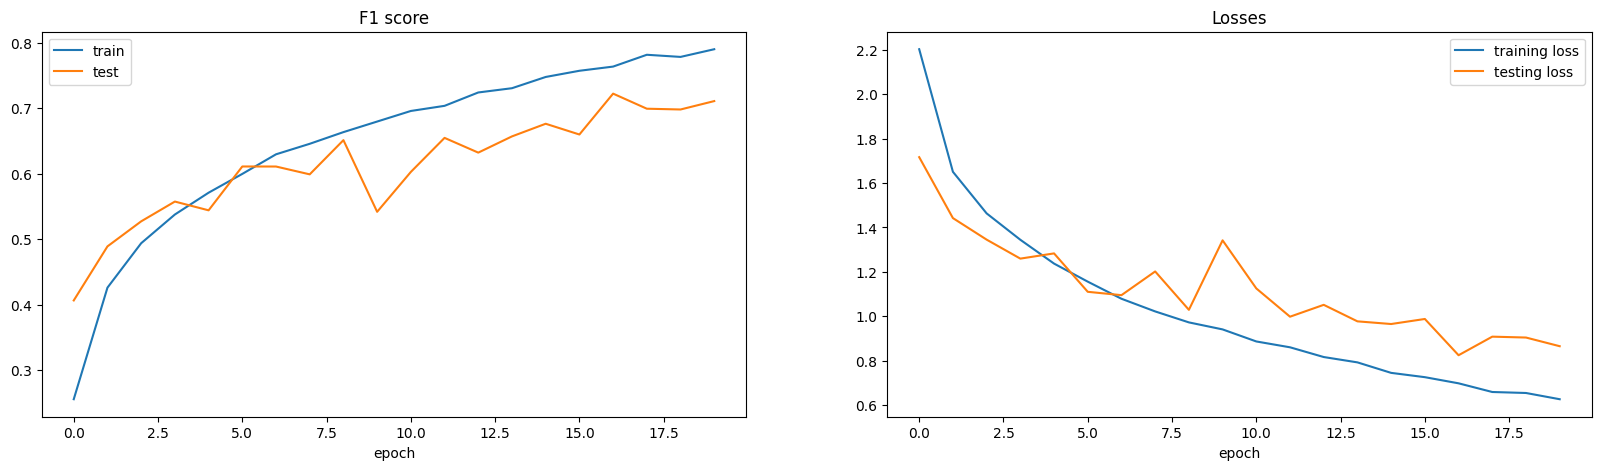

In [40]:
n=20
fig, ax=plt.subplots(1,2, figsize=(20,5))
ax[0].plot(list(range(len(train_accs[:n]))), train_accs[:n], label="train")
ax[0].plot(list(range(len(test_accs[:n]))), test_accs[:n], label="test") 
ax[0].legend(loc='best')
ax[0].set_title("F1 score")
ax[0].set_xlabel("epoch")
ax[1].set_xlabel("epoch")
ax[1].plot(list(range(len(train_loss[:n]))), train_loss[:n], label="training loss")
ax[1].plot(list(range(len(test_loss[:n]))), test_loss[:n], label="testing loss")
ax[1].legend(loc='best')
ax[1].set_title("Losses")
ax[1].set_xlabel("epoch")

Evaluate the model:

In [42]:
loss_fun = nn.CrossEntropyLoss
model = CNNModel1(lr=0.01, loss_fn=loss_fun,fc_dropout_rate=0.5, weight_decay=0.0001, scheduler=True)
model.load_state_dict(torch.load("net_weights_epoch_19.pth"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model.to(device)
y_pred_ = []
y_test = []
i=0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        y_test.extend(labels)
        outputs = model(inputs)
        if(i==0):
            y_score = torch.nn.functional.softmax(outputs, dim=1).squeeze().numpy()
        else:
            tmp = torch.nn.functional.softmax(outputs, dim=1).squeeze().numpy()
            y_score = np.vstack((y_score, tmp))    
        i=i+1
        predicted = outputs.argmax(axis=1)
        y_pred_.extend(list(predicted.numpy()))
        del inputs, outputs
class_weights_test = class_weight.compute_class_weight(class_weight='balanced', classes=list(set(y_test)), y=y_test)
sample_class_weights = [class_weights_test[i] for i in y_test]
f1=f1_score(y_test, y_pred_, average='weighted', sample_weight=sample_class_weights)
print('F1 score on test data: {}'.format(f1))

torch.Size([512, 4096]) torch.Size([512])
torch.Size([14, 512]) torch.Size([14])
F1 score on test data: 0.7043676647832411 %


Visualizing some predictions:

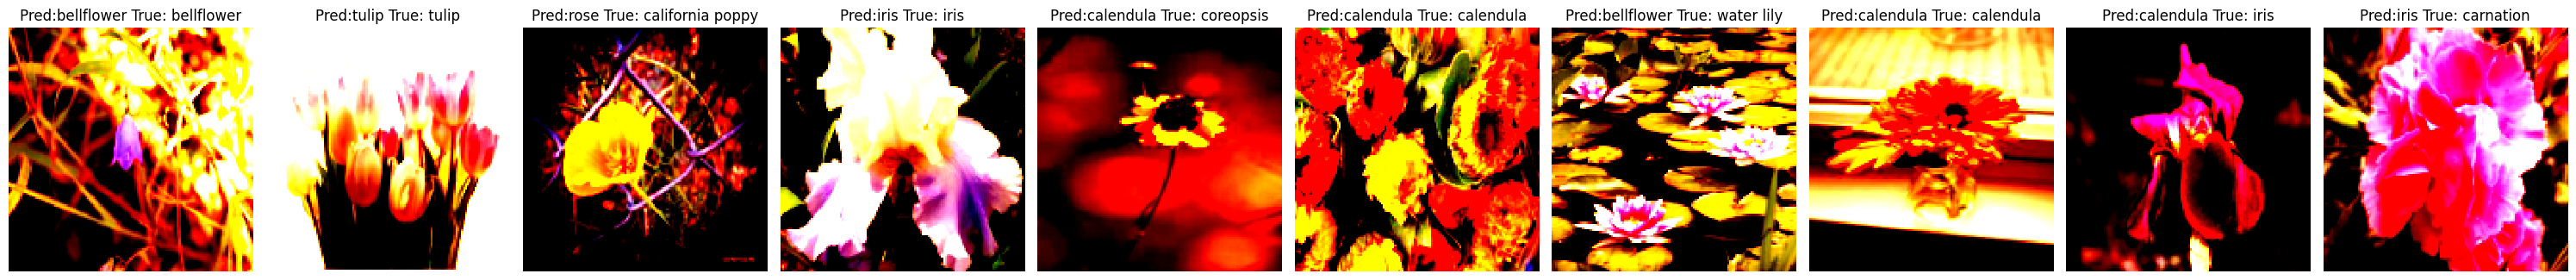

In [59]:
num_to_show = 10
random_images = np.random.randint(0,len(test_data), 10)
plt.figure(figsize = (30, 30))
count=0
for i in random_images:
    input_img = test_data[i][0].unsqueeze(0).to(device)
    pred_label = model(input_img).argmax(axis=1)
    image = test_data[i][0].permute(1,2,0)
    image = torch.clamp(image, min=0, max=1) 
    image = image.numpy()
    true_label = trans_dic2[test_data[i][1]]
    plt.subplot(2, num_to_show, count + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    title = "Pred:"+str(trans_dic2[pred_label.numpy()[0]])+" True: "+str(true_label)
    plt.title(title)
    count += count
plt.tight_layout()
plt.show()

Confusion matrix:

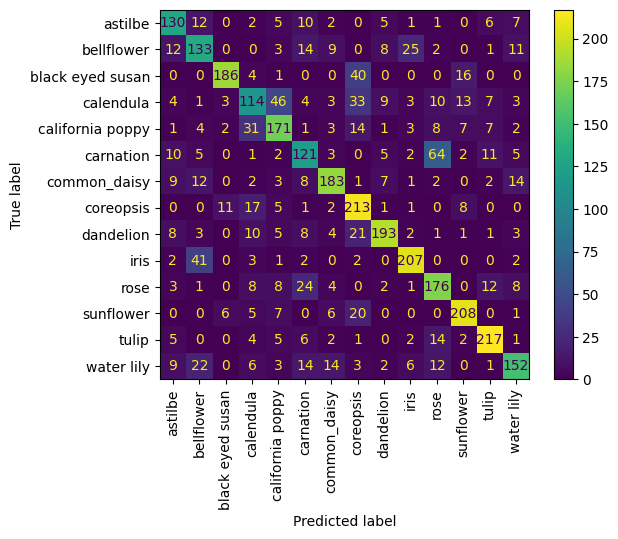

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
labs=list(set(y_test))
cf_matrix = confusion_matrix(y_test, y_pred_)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=trans_dic2.values())
disp.plot(xticks_rotation='vertical')
plt.show()